# Solution Optimization Analysis

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Load Datasets

In [2]:
raw_textgrad = pd.read_csv("results/raw_textgrad.csv")
tv_textgrad = pd.read_csv("results/tv_textgrad.csv")
tv2_textgrad = pd.read_csv("results/tv2_textgrad.csv")
tv3_textgrad = pd.read_csv("results/tv3_textgrad.csv")
tv4_textgrad = pd.read_csv("results/tv4_textgrad.csv")

## Functions

In [3]:
sources = {
    "GPQA-Diamond": "GPQA-Diamond",
    "MMLU-ML": "MMLU-ML",
    "MMLU-CP": "MMLU-CP",
}

In [4]:
def extract_answer(text):
    # Now extract correctly
    match = re.search(r"(?i)Answer\s*:\s*([A-D])", text, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return "Z" # Z -> means for None (Incorrect Answer)

In [5]:
def process_answer(row_data):
    data = {
        "source": row_data["source"],
        "correct_answer": row_data["correct_answer"],
        "initial_answer": extract_answer(row_data["raw_solution"]),
        "zero_shot_answer": extract_answer(row_data["solution_1"]),
        "solution_answer_2": extract_answer(row_data["solution_2"]),
        "solution_answer_3": extract_answer(row_data["solution_3"]),
        "solution_answer_4": extract_answer(row_data["solution_4"]),
        "final_answer": extract_answer(row_data["solution_5"])
    }
    # Get zero-shot & final result
    data["zero_shot_result"] = data["correct_answer"] == data["zero_shot_answer"]
    data["final_result"] = data["correct_answer"] == data["final_answer"]

    # Majority voting among solution_1 to solution_5
    voted_answers = [
        data["zero_shot_answer"],
        data["solution_answer_2"],
        data["solution_answer_3"],
        data["solution_answer_4"],
        data["final_answer"]
    ]
    
    # Filter out None values
    voted_answers = [a for a in voted_answers if a is not None]

    # Get majority answer
    if voted_answers:
        majority_vote = Counter(voted_answers).most_common(1)[0][0]
    else:
        majority_vote = None

    data["majority_answer"] = majority_vote
    data["majority_result"] = data["correct_answer"] == majority_vote

    return data


In [6]:
def process_result_data(result_df):
    processed_answer = []
    for index, row in result_df.iterrows():
        processed_answer.append(process_answer(row))
    return processed_answer

In [7]:
def calculate_true_percentages(df, columns):
    result = {}
    for col in columns:
        if col not in df.columns:
            result[col] = None
            continue
        non_null_count = df[col].notnull().sum()
        if non_null_count == 0:
            result[col] = None
            continue
        true_count = df[col].sum()
        result[col] = round((true_count / non_null_count) * 100, 2)
    return result

In [8]:
def get_clean_processed_data(dataset):
    processed_answer_list = process_result_data(dataset)
    processed_answer = pd.DataFrame(processed_answer_list)
    clean_processed_answer = processed_answer.dropna()
    return clean_processed_answer

def analyze_percentage_data(dataset):
    columns_to_check = ["zero_shot_result", "final_result", "majority_result"]
    clean_df = get_clean_processed_data(dataset)
    overall_result = {}

    for name, source_key in {**sources, "Combined": None}.items():
        if source_key is not None:
            df_source = clean_df[clean_df["source"] == source_key]
        else:
            df_source = clean_df
        result = calculate_true_percentages(df_source, columns_to_check)
        overall_result[name] = result

    return overall_result

def analyze_visual_iteration_data(dataset):
    iterations = ["zero_shot_answer", "solution_answer_2", "solution_answer_3", "solution_answer_4", "final_answer"]
    clean_df = get_clean_processed_data(dataset)

    plt.figure(figsize=(10, 6))

    for name, source_key in {**sources, "Combined": None}.items():
        if source_key is not None:
            df_source = clean_df[clean_df["source"] == source_key]
        else:
            df_source = clean_df

        accuracies = []
        for col in iterations:
            correct = df_source[col] == df_source["correct_answer"]
            accuracy = correct.mean() * 100  # convert to percentage
            accuracies.append(accuracy)

        plt.plot(iterations, accuracies, marker='o', label=name)

    plt.title("Accuracy at Each Iteration by Source")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## 1. Analysis Raw TextGrad

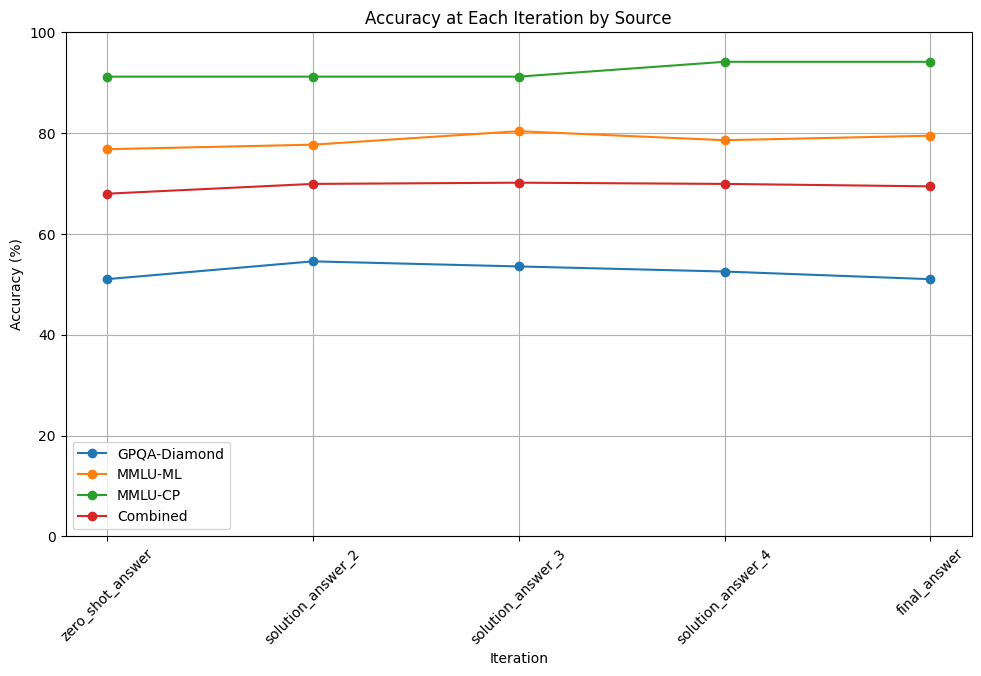

In [9]:
# Visualization
analyze_visual_iteration_data(raw_textgrad)

In [10]:
# Percentages
result = analyze_percentage_data(raw_textgrad)
result

{'GPQA-Diamond': {'zero_shot_result': np.float64(51.01),
  'final_result': np.float64(51.01),
  'majority_result': np.float64(58.59)},
 'MMLU-ML': {'zero_shot_result': np.float64(76.79),
  'final_result': np.float64(79.46),
  'majority_result': np.float64(83.93)},
 'MMLU-CP': {'zero_shot_result': np.float64(91.18),
  'final_result': np.float64(94.12),
  'majority_result': np.float64(97.06)},
 'Combined': {'zero_shot_result': np.float64(67.96),
  'final_result': np.float64(69.42),
  'majority_result': np.float64(75.0)}}

## 2. Analysis TextGrad with TextualVerifier

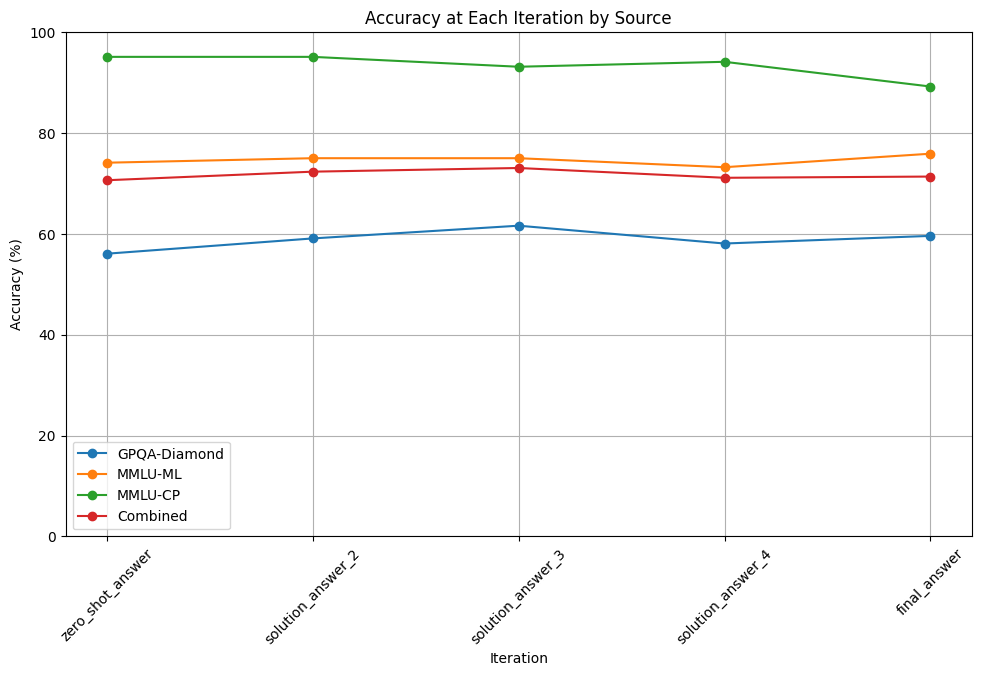

In [11]:
# Visualization
analyze_visual_iteration_data(tv_textgrad)

In [12]:
# Percentages
tv_result = analyze_percentage_data(tv_textgrad)
tv_result

{'GPQA-Diamond': {'zero_shot_result': np.float64(56.06),
  'final_result': np.float64(59.6),
  'majority_result': np.float64(61.11)},
 'MMLU-ML': {'zero_shot_result': np.float64(74.11),
  'final_result': np.float64(75.89),
  'majority_result': np.float64(78.57)},
 'MMLU-CP': {'zero_shot_result': np.float64(95.1),
  'final_result': np.float64(89.22),
  'majority_result': np.float64(94.12)},
 'Combined': {'zero_shot_result': np.float64(70.63),
  'final_result': np.float64(71.36),
  'majority_result': np.float64(74.03)}}

## 3. Analysis TextGrad with TextualVerifierV2

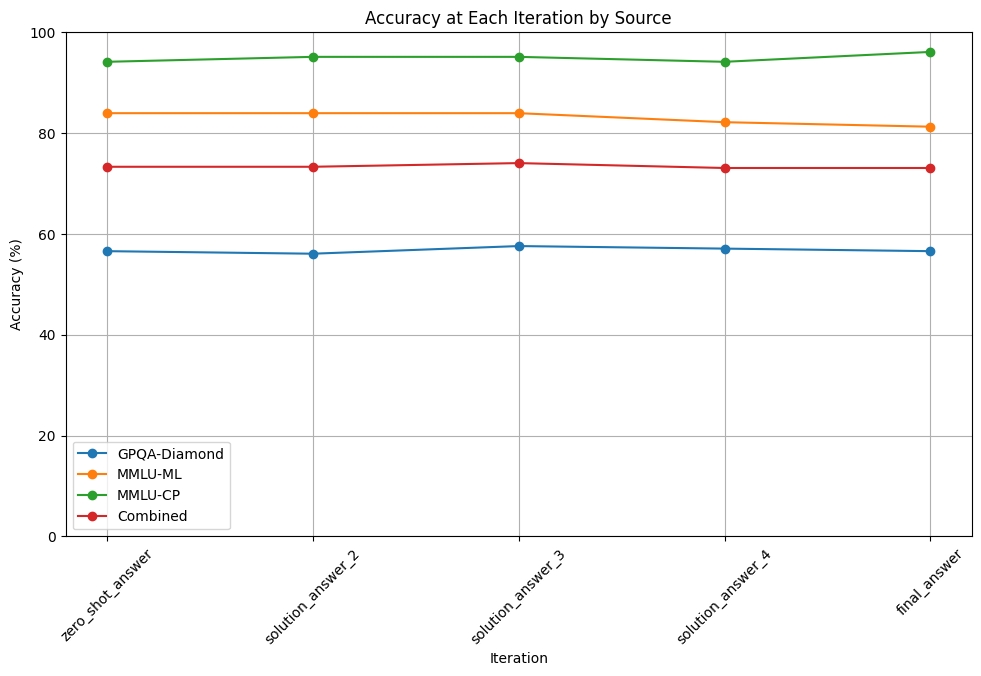

In [13]:
# Visualization
analyze_visual_iteration_data(tv2_textgrad)

In [14]:
# Percentages
tv2_result = analyze_percentage_data(tv2_textgrad)
tv2_result

{'GPQA-Diamond': {'zero_shot_result': np.float64(56.57),
  'final_result': np.float64(56.57),
  'majority_result': np.float64(59.09)},
 'MMLU-ML': {'zero_shot_result': np.float64(83.93),
  'final_result': np.float64(81.25),
  'majority_result': np.float64(85.71)},
 'MMLU-CP': {'zero_shot_result': np.float64(94.12),
  'final_result': np.float64(96.08),
  'majority_result': np.float64(96.08)},
 'Combined': {'zero_shot_result': np.float64(73.3),
  'final_result': np.float64(73.06),
  'majority_result': np.float64(75.49)}}

## 4. Analysis TextGrad with TextualVerifierV3

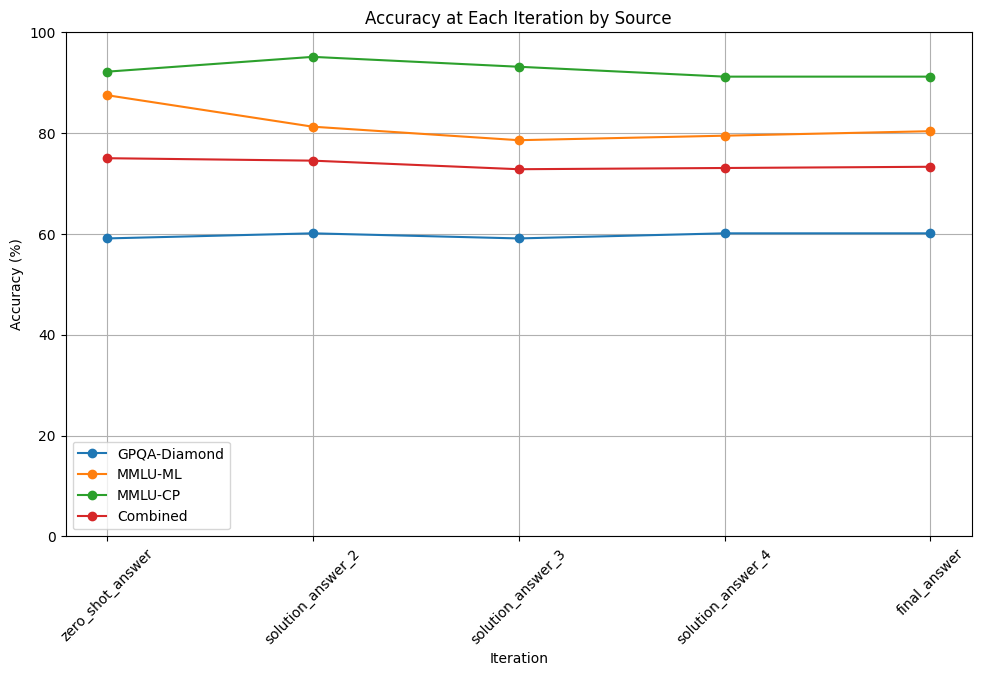

In [15]:
# Visualization
analyze_visual_iteration_data(tv3_textgrad)

In [16]:
# Percentages
tv3_result = analyze_percentage_data(tv3_textgrad)
tv3_result

{'GPQA-Diamond': {'zero_shot_result': np.float64(59.09),
  'final_result': np.float64(60.1),
  'majority_result': np.float64(60.61)},
 'MMLU-ML': {'zero_shot_result': np.float64(87.5),
  'final_result': np.float64(80.36),
  'majority_result': np.float64(83.04)},
 'MMLU-CP': {'zero_shot_result': np.float64(92.16),
  'final_result': np.float64(91.18),
  'majority_result': np.float64(93.14)},
 'Combined': {'zero_shot_result': np.float64(75.0),
  'final_result': np.float64(73.3),
  'majority_result': np.float64(74.76)}}

## 5. Analysis TextGrad with TextualVerifierV4

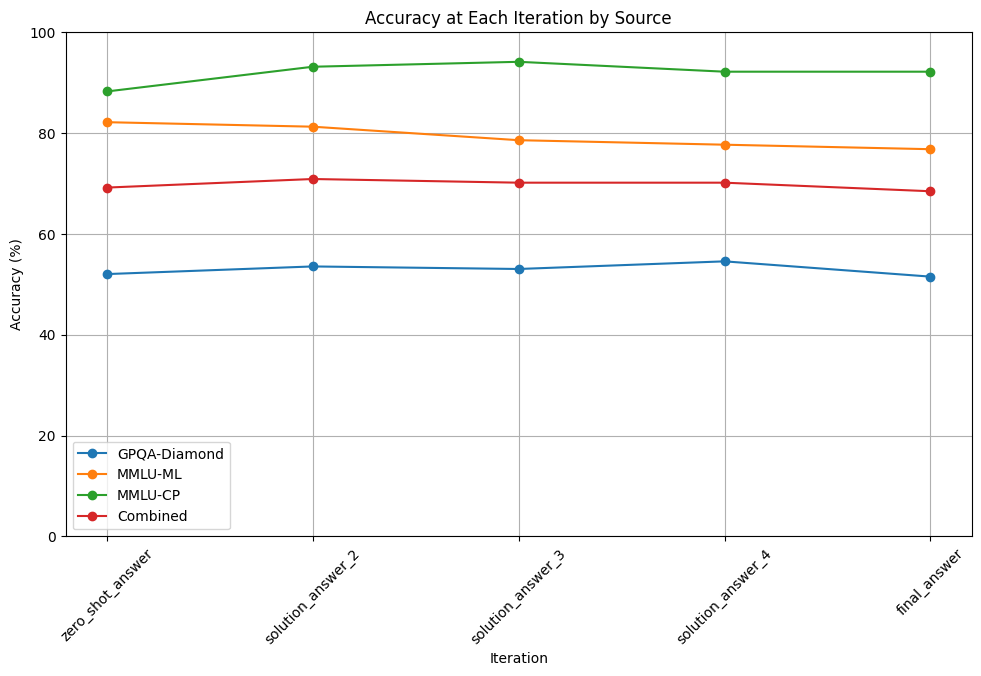

In [17]:
# Visualization
analyze_visual_iteration_data(tv4_textgrad)

In [18]:
# Percentages
tv4_result = analyze_percentage_data(tv4_textgrad)
tv4_result

{'GPQA-Diamond': {'zero_shot_result': np.float64(52.02),
  'final_result': np.float64(51.52),
  'majority_result': np.float64(55.56)},
 'MMLU-ML': {'zero_shot_result': np.float64(82.14),
  'final_result': np.float64(76.79),
  'majority_result': np.float64(83.04)},
 'MMLU-CP': {'zero_shot_result': np.float64(88.24),
  'final_result': np.float64(92.16),
  'majority_result': np.float64(95.1)},
 'Combined': {'zero_shot_result': np.float64(69.17),
  'final_result': np.float64(68.45),
  'majority_result': np.float64(72.82)}}